In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append('../../')
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from DataPreparation.Ingestion.Ingestion import read_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from DataPreparation.Preprocessing.Preprocessing import preprocess_data

#### Ingestion

In [2]:
df = read_data(
    path='../../../DataFiles/house-prices-advanced-regression-techniques/')

In [3]:
x_train_p, y_train, x_val_p, y_val = preprocess_data(df)

# Print Nan values
print(x_train_p.isnull().sum())
print(x_train_p.shape)

columns having only 2 unique values: 3
['Street', 'Utilities', 'CentralAir']
columns having only <=10 unique values: 33
['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
columns having only <=10 unique values: 3
['Neighborhood', 'Exterior1st', 'Exterior2nd']
MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleType_New             0
SaleType_WD              0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 138, dtype: int64
(1095, 138)


#### Initiating the Model

In [4]:
xgb = XGBRegressor(random_state=17)

xgb_params = {"learning_rate": [0.1, 0.01],
              "max_depth": [5, 8],
              "n_estimators": [100, 500, 1000],
              "subsample": [0.7, 1]}

xgb_random = RandomizedSearchCV(estimator=xgb,
                                param_distributions=xgb_params,
                                verbose=True, n_iter=100,
                                n_jobs=-1)

xgb_random.fit(x_train_p, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/ziad/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=17, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [5, 8],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.7, 1]},
                   verbose=True)

In [5]:
def plot_importance(model, features, num=10, save=False):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

{'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01}


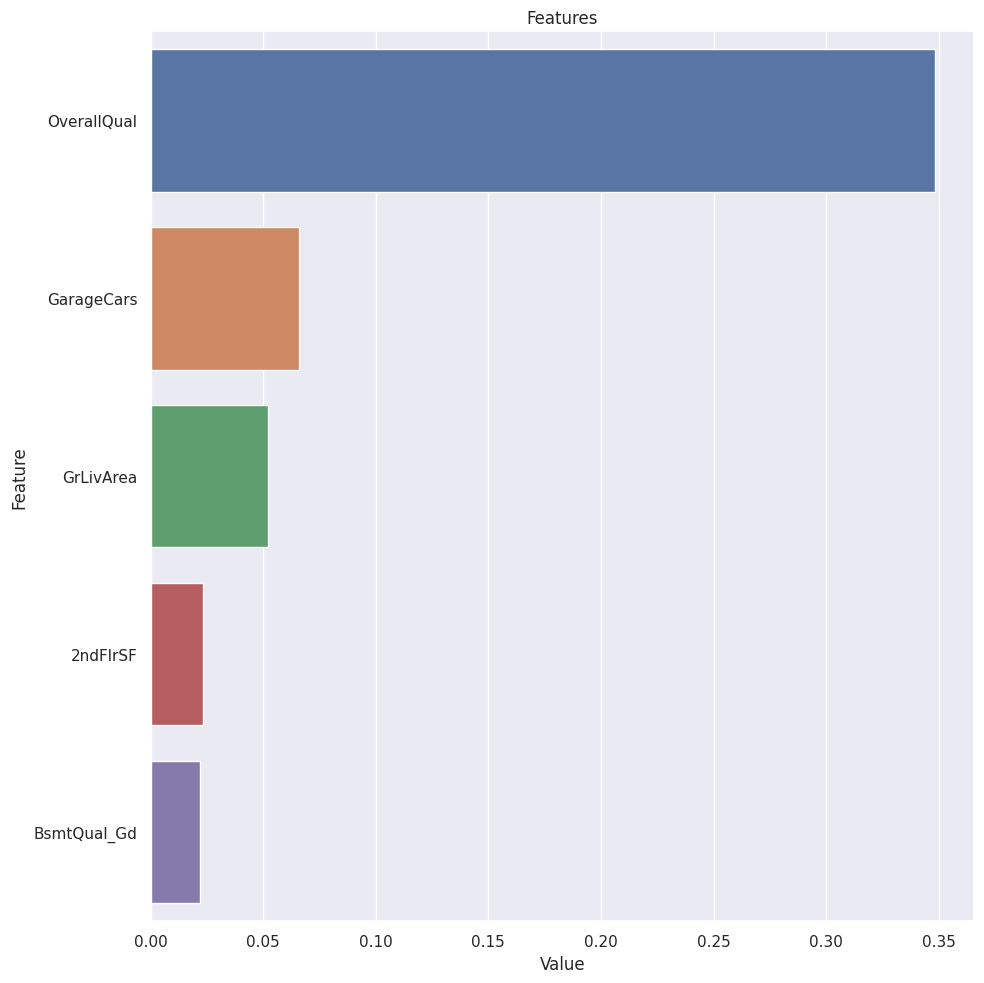

In [6]:
print(xgb_random.best_params_)

xgb_random_final = xgb.set_params(
    **xgb_random.best_params_, random_state=17).fit(x_train_p, y_train)

plot_importance(xgb_random_final, x_train_p, num=5)

#### Validating the Model

In [7]:
preds_xgb = xgb_random_final.predict(x_val_p)
mae_xgb = mean_absolute_error(y_val, preds_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds_xgb))

print(mae_xgb)
print(rmse_xgb)

15089.27084760274
23641.696840991608


#### Saving the Model